## Prep Postgres, Ducklake and Clickhouse for Testing

In [1]:
%pip install duckdb --quiet
%pip install --upgrade s3fs --quiet
%pip install connectorx adbc_driver_postgresql psycopg2-binary --quiet
%pip install clickhouse-connect --quiet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os

import clickhouse_connect
import duckdb
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns
from dotenv import load_dotenv

load_dotenv()
pass

In [3]:
con = duckdb.connect()
con.execute("install ducklake;")
con.execute("install postgres;")

con.execute(
    """
        CREATE SECRET (
            TYPE postgres,
            HOST '{host}',
            PORT {port},
            DATABASE {db},
            USER '{user}',
            PASSWORD '{password}'
        );
    """.format(
        host=os.getenv("POSTGRES_HOST"),
        port=os.getenv("POSTGRES_PORT"),
        user=os.getenv("DUCKLAKE_PG_LOGIN"),
        password=os.getenv("DUCKLAKE_PG_PASS"),
        db="ducklake_catalog",
    )
)

con.execute(
    """
        CREATE OR REPLACE SECRET secret (
            TYPE s3,
            ENDPOINT '{endpoint}',
            KEY_ID '{key_id}',
            SECRET '{secret}',
            URL_STYLE 'path',
            USE_SSL 'false'
        );
    """.format(
        endpoint="seaweedfs-s3.seaweedfs:8333",
        key_id=os.getenv("S3_AWS_ACCESS_KEY_ID"),
        secret=os.getenv("S3_AWS_SECRET_ACCESS_KEY"),
    )
)

con.execute(
    """
        ATTACH 'ducklake:postgres:dbname=ducklake_catalog host={host}' AS my_ducklake
            (DATA_PATH 's3://ducklake/');
        USE my_ducklake;
    """.format(host=os.getenv("POSTGRES_HOST"))
)

In [4]:
host = os.getenv("CLICKHOUSE_HOST")
username = os.getenv("CLICKHOUSE_USER")
password = os.getenv("CLICKHOUSE_PASSWORD")

ch_client = clickhouse_connect.get_client(
    host=host,
    port=8123,
    username=username,
    password=password,
)

## Run some queries agains hard drive data in DuckLake and PostgreSQL

### Count

In [5]:
%%time
## estimate not precise but fast
df = pl.read_database_uri(
    query="SELECT reltuples::bigint FROM pg_class WHERE oid = 'raw.hard_drive_data'::regclass;",
    uri=os.getenv("POSTGRES_CONN_STR"),
)
df

CPU times: user 6.64 ms, sys: 6.53 ms, total: 13.2 ms
Wall time: 27.4 ms


reltuples
i64
56592856


In [6]:
%%time
con.execute(
    """
        SELECT count(*)
        FROM hard_drive_data;
    """
).fetchall()

CPU times: user 137 ms, sys: 28.9 ms, total: 166 ms
Wall time: 186 ms


[(56608028,)]

In [7]:
%%time
ch_client.query(
    """
    SELECT COUNT(1) FROM dwh.backblaze_hard_drive_data
    """
).result_rows

CPU times: user 2.6 ms, sys: 162 µs, total: 2.76 ms
Wall time: 6.05 ms


[(56608028,)]

### Top 3 models by total capacity on 2025-01-01

Postgres has index on date

In [8]:
%%time
df = pl.read_database_uri(
    query="""
        SELECT model, sum(capacity_bytes) / 1024^5 as total_capacity_pib_per_model
        FROM raw.hard_drive_data
        WHERE date = '2025-01-01'
        GROUP BY model
        ORDER BY total_capacity_pib_per_model DESC
        LIMIT 3
        """,
    uri=os.getenv("POSTGRES_CONN_STR"),
)
df

CPU times: user 4.84 ms, sys: 223 µs, total: 5.07 ms
Wall time: 116 ms


model,total_capacity_pib_per_model
str,f64
"""WDC WUH722222ALE6L4""",586.243143
"""TOSHIBA MG08ACA16TA""",570.29949
"""ST16000NM001G""",477.511597


In [9]:
%%time
con.execute(
    """
        SELECT model, sum(capacity_bytes) / 1024^5 as total_capacity_pib_per_model,
        FROM hard_drive_data
        WHERE date = '2025-01-01'
        GROUP BY model
        ORDER BY 2 DESC
        LIMIT 3;
    """
).fetch_df()

CPU times: user 28.7 ms, sys: 13.3 ms, total: 42 ms
Wall time: 52 ms


,model,total_capacity_pib_per_model
0,WDC WUH722222ALE6L4,586.243143
1,TOSHIBA MG08ACA16TA,570.299490
2,ST16000NM001G,477.511597


In [10]:
%%time
ch_client.query_df(
    """
        SELECT model, sum(capacity_bytes) / pow(1024, 5) as total_capacity_pib_per_model
        FROM dwh.backblaze_hard_drive_data 
        WHERE date = '2025-01-01'
        GROUP BY model
        ORDER BY 2 DESC
        LIMIT 3
    """
)

CPU times: user 2.21 ms, sys: 2.1 ms, total: 4.31 ms
Wall time: 50 ms


,model,total_capacity_pib_per_model
0,WDC WUH722222ALE6L4,586.243143
1,TOSHIBA MG08ACA16TA,570.299490
2,ST16000NM001G,477.511597


### Drive volume distribution per data center and model

In [11]:
%%time
storage_per_model_per_datacenter_pg = pl.read_database_uri(
    query="""
        SELECT model, datacenter, sum(capacity_bytes) / 1024^5 as total_capacity_pib_per_model
        FROM raw.hard_drive_data
        WHERE date = '2025-01-01'
        GROUP BY model, datacenter
        ORDER BY 3 DESC
        """,
    uri=os.getenv("POSTGRES_CONN_STR"),
)
storage_per_model_per_datacenter_pg = storage_per_model_per_datacenter_pg.to_pandas()
storage_per_model_per_datacenter_pg

CPU times: user 8.98 ms, sys: 248 µs, total: 9.23 ms
Wall time: 134 ms


,model,datacenter,total_capacity_pib_per_model
0,ST16000NM001G,phx1,306.957529
1,TOSHIBA MG08ACA16TA,iad1,238.698952
2,TOSHIBA MG08ACA16TA,phx1,209.195557
3,TOSHIBA MG07ACA14TA,phx1,205.636924
4,WDC WUH722222ALE6L4,iad1,187.591553
...,...,...,...
160,Seagate SSD,phx1,0.000444
161,WDC WD5000LPVX,sac2,0.000444
162,WDC WD5000BPKT,sac2,0.000444
163,Seagate FireCuda 120 SSD ZA500GM10001,phx1,0.000444


In [12]:
%%time
storage_per_model_per_datacenter_dl = con.execute(
    """
        SELECT model, datacenter, sum(capacity_bytes) / 1024^5 as total_capacity_pib_per_model,
        FROM hard_drive_data
        WHERE date = '2025-01-01'
        GROUP BY model, datacenter
        ORDER BY 3 DESC
    """
).fetch_df()
storage_per_model_per_datacenter_dl

CPU times: user 30.5 ms, sys: 13.2 ms, total: 43.8 ms
Wall time: 48.8 ms


,model,datacenter,total_capacity_pib_per_model
0,ST16000NM001G,phx1,306.957529
1,TOSHIBA MG08ACA16TA,iad1,238.698952
2,TOSHIBA MG08ACA16TA,phx1,209.195557
3,TOSHIBA MG07ACA14TA,phx1,205.636924
4,WDC WUH722222ALE6L4,iad1,187.591553
...,...,...,...
160,Seagate SSD,phx1,0.000444
161,WDC WD5000LPVX,sac2,0.000444
162,Seagate FireCuda 120 SSD ZA500GM10001,phx1,0.000444
163,WDC WD5000BPKT,sac2,0.000444


In [13]:
%%time
storage_per_model_per_datacenter_ch = ch_client.query_df(
    """
        SELECT model, datacenter, sum(capacity_bytes) / pow(1024, 5)  as total_capacity_pib_per_model
        FROM dwh.backblaze_hard_drive_data 
        WHERE date = '2025-01-01'
        GROUP BY model, datacenter
        ORDER BY 3 DESC
        SETTINGS max_bytes_before_external_group_by = '1000000000'
    """
)
storage_per_model_per_datacenter_ch

CPU times: user 3.62 ms, sys: 164 µs, total: 3.79 ms
Wall time: 44.4 ms


,model,datacenter,total_capacity_pib_per_model
0,ST16000NM001G,phx1,306.957529
1,TOSHIBA MG08ACA16TA,iad1,238.698952
2,TOSHIBA MG08ACA16TA,phx1,209.195557
3,TOSHIBA MG07ACA14TA,phx1,205.636924
4,WDC WUH722222ALE6L4,iad1,187.591553
...,...,...,...
160,Seagate SSD,phx1,0.000444
161,WDC WD5000BPKT,sac2,0.000444
162,Seagate FireCuda 120 SSD ZA500GM10001,phx1,0.000444
163,WDC WD5000LPVX,sac2,0.000444


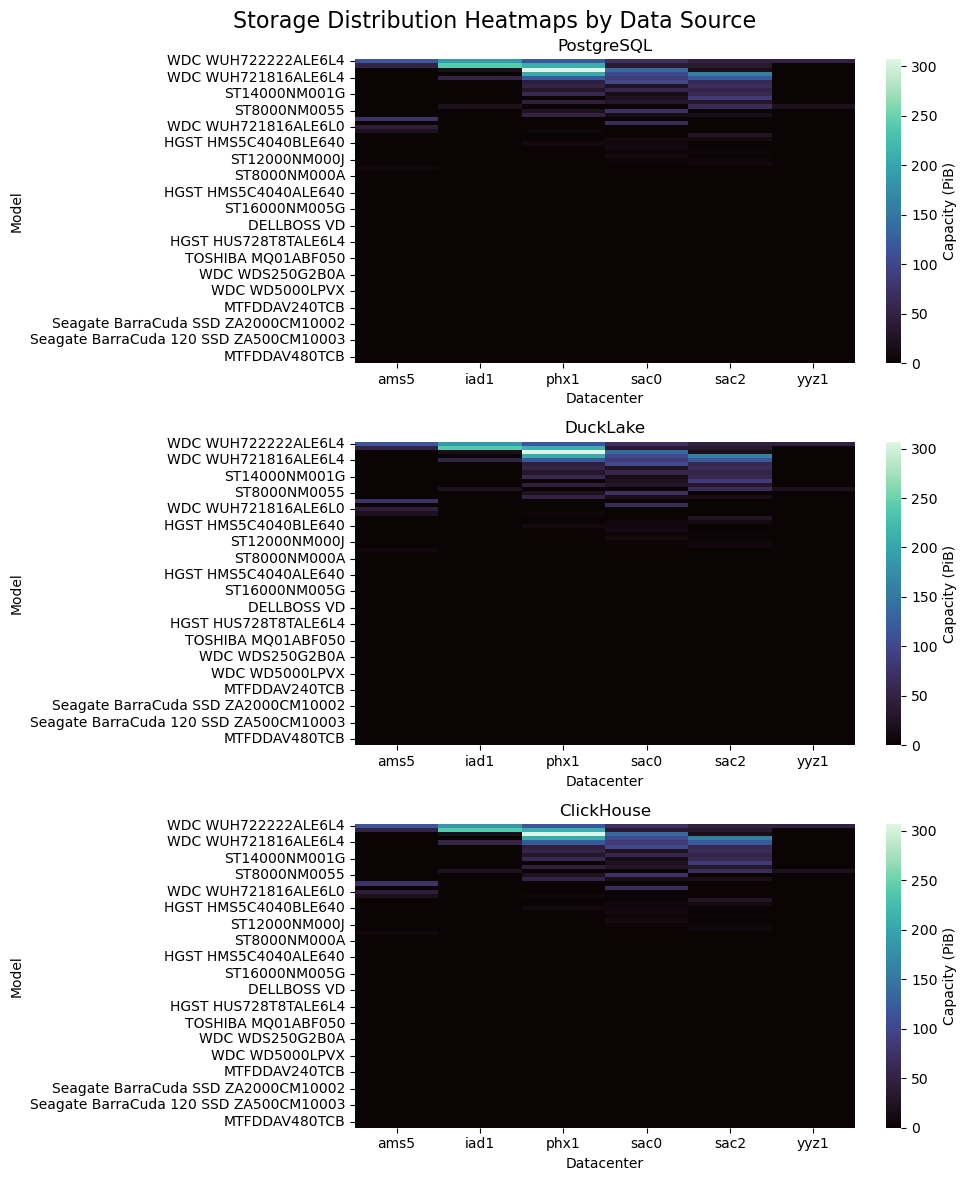

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
fig.suptitle('Storage Distribution Heatmaps by Data Source', fontsize=16)

# Create pivot tables for heatmaps
datasets = [
    (storage_per_model_per_datacenter_pg, 'PostgreSQL'),
    (storage_per_model_per_datacenter_dl, 'DuckLake'),
    (storage_per_model_per_datacenter_ch, 'ClickHouse'),
]

for idx, (data, title) in enumerate(datasets):
    row = idx

    pivot_data = data.pivot_table(
        index='model',
        columns='datacenter',
        values='total_capacity_pib_per_model',
        fill_value=0
    )

    pivot_data = pivot_data.loc[pivot_data.sum(
        axis=1).sort_values(ascending=False).index]

    sns.heatmap(
        pivot_data,
        ax=axes[row],
        annot=False,
        cmap='mako',
        cbar_kws={'label': 'Capacity (PiB)'}
    )

    axes[row].set_title(f'{title}')
    axes[row].set_ylabel('Model')
    axes[row].set_xlabel('Datacenter')

plt.tight_layout()
plt.show()

### Drive models distribution per data center

In [27]:
%%time

drive_count_per_model_datacenter_pg = pl.read_database_uri(
    query="""
        SELECT model, datacenter, count(1) as drive_count
        FROM raw.hard_drive_data
        WHERE date = '2025-01-01'
        GROUP BY model, datacenter
        ORDER BY 3 DESC
        """,
    uri=os.getenv("POSTGRES_CONN_STR"),
).to_pandas()
drive_count_per_model_datacenter_pg

CPU times: user 5.7 ms, sys: 271 µs, total: 5.97 ms
Wall time: 121 ms


,model,datacenter,drive_count
0,ST16000NM001G,phx1,21599
1,TOSHIBA MG08ACA16TA,iad1,16796
2,TOSHIBA MG07ACA14TA,phx1,16537
3,TOSHIBA MG08ACA16TA,phx1,14720
4,TOSHIBA MG07ACA14TA,sac2,12920
...,...,...,...
160,Samsung SSD 850 EVO 1TB,phx1,1
161,WDC WD5000BPKT,sac2,1
162,Samsung SSD 860 PRO 2TB,sac0,1
163,HGST HUS726040ALE610,sac0,1


In [28]:
%%time
drive_count_per_model_datacenter_dl = con.execute(
    """
        SELECT model, datacenter, count(1) as drive_count
        FROM hard_drive_data
        WHERE date = '2025-01-01'
        GROUP BY model, datacenter
        ORDER BY 3 DESC
    """
).fetch_df()
drive_count_per_model_datacenter_dl

CPU times: user 30.2 ms, sys: 7.66 ms, total: 37.8 ms
Wall time: 39.8 ms


,model,datacenter,drive_count
0,ST16000NM001G,phx1,21599
1,TOSHIBA MG08ACA16TA,iad1,16796
2,TOSHIBA MG07ACA14TA,phx1,16537
3,TOSHIBA MG08ACA16TA,phx1,14720
4,TOSHIBA MG07ACA14TA,sac2,12920
...,...,...,...
160,WDC WD5000LPVX,sac2,1
161,WDC WD5000BPKT,sac2,1
162,Samsung SSD 860 PRO 2TB,sac0,1
163,HGST HUS726040ALE610,sac0,1


In [29]:
%%time
drive_count_per_model_datacenter_ch = ch_client.query_df(
    """
        SELECT model, datacenter, count(1) as drive_count
        FROM dwh.backblaze_hard_drive_data 
        WHERE date = '2025-01-01'
        GROUP BY model, datacenter
        ORDER BY 3 DESC
        SETTINGS max_bytes_before_external_group_by = '1000000000'
    """
)
drive_count_per_model_datacenter_ch

CPU times: user 1.22 ms, sys: 2.8 ms, total: 4.02 ms
Wall time: 13.9 ms


,model,datacenter,drive_count
0,ST16000NM001G,phx1,21599
1,TOSHIBA MG08ACA16TA,iad1,16796
2,TOSHIBA MG07ACA14TA,phx1,16537
3,TOSHIBA MG08ACA16TA,phx1,14720
4,TOSHIBA MG07ACA14TA,sac2,12920
...,...,...,...
160,ST1000LM024 HN,sac0,1
161,SSDSCKKB240GZR,sac0,1
162,Samsung SSD 860 PRO 2TB,sac0,1
163,WDC WD5000LPVX,sac2,1


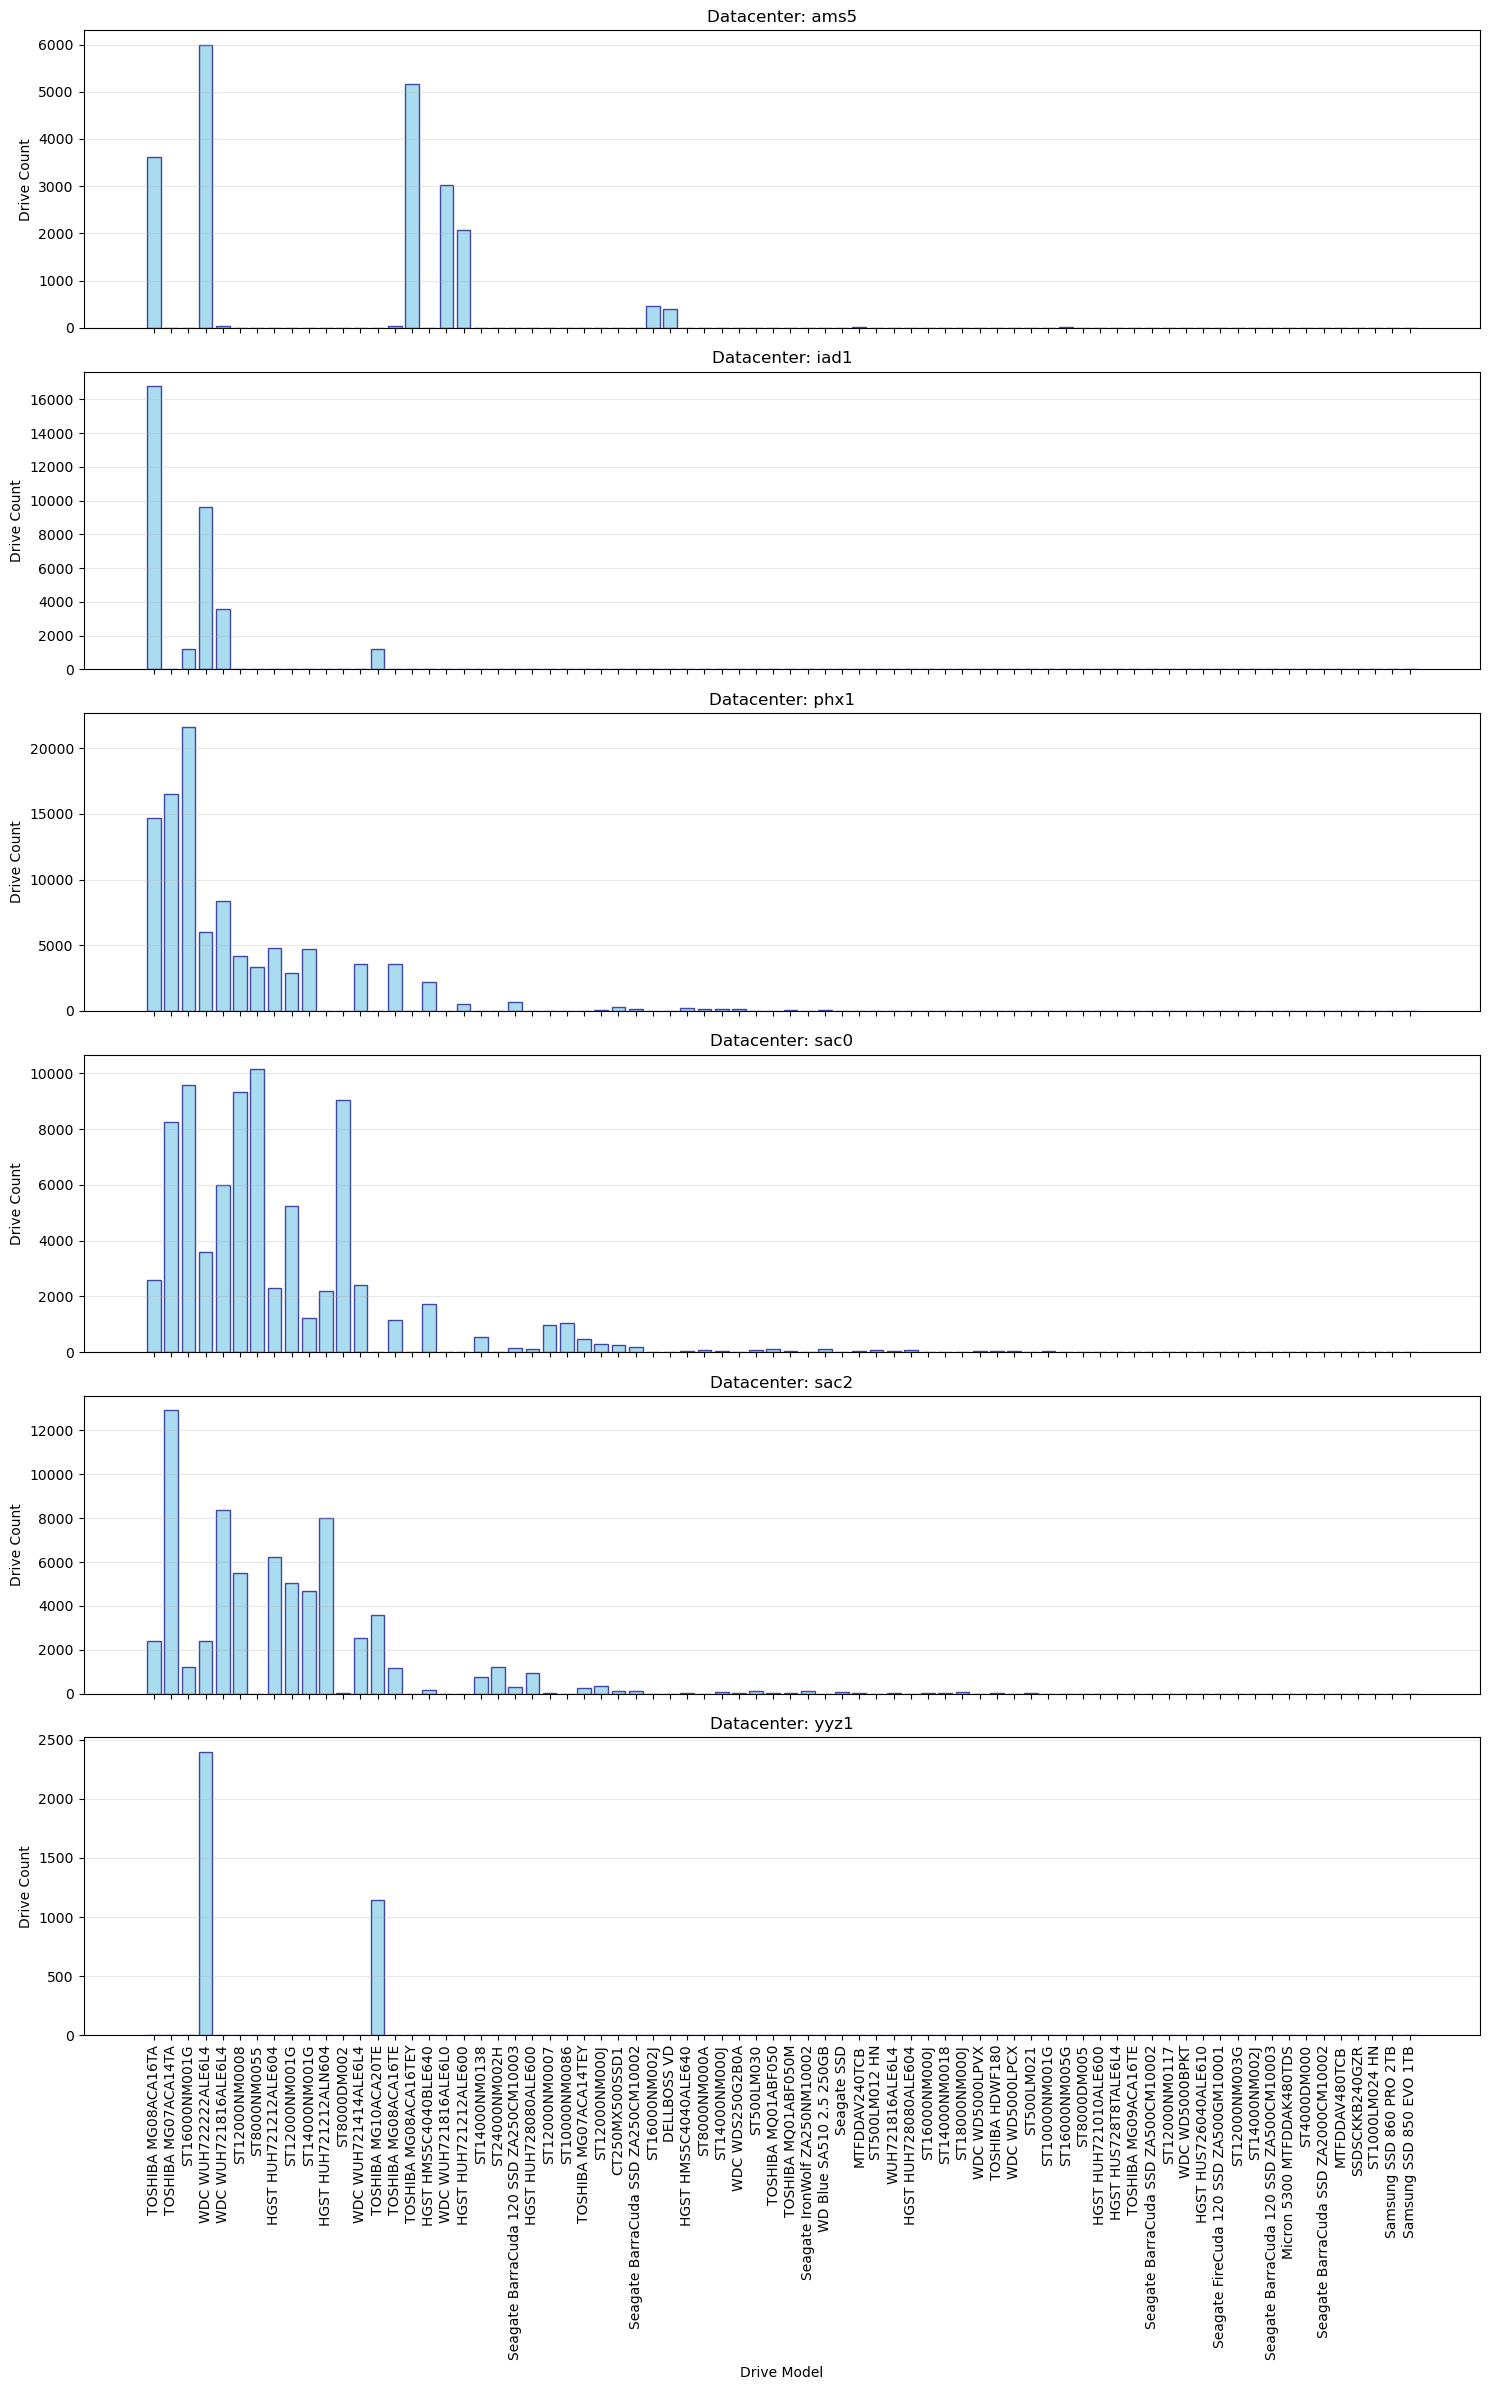

In [73]:
drive_models = drive_count_per_model_datacenter_dl.groupby(
    'model')['drive_count'].sum().sort_values(ascending=False)

datacenters = sorted(
    drive_count_per_model_datacenter_dl['datacenter'].unique())

fig, axes = plt.subplots(len(datacenters), 1, figsize=(
    15, 4 * len(datacenters)), sharex=True)

for i, datacenter in enumerate(datacenters):
    dc_data = drive_count_per_model_datacenter_dl[
        drive_count_per_model_datacenter_dl['datacenter'] == datacenter]

    model_counts = {}
    for model in drive_models.index:
        count = dc_data[dc_data['model'] == model]['drive_count'].sum()
        model_counts[model] = count

    models = list(model_counts.keys())
    counts = list(model_counts.values())

    axes[i].bar(models, counts, color='skyblue', edgecolor='navy', alpha=0.7)
    axes[i].set_title(f'Datacenter: {datacenter}')
    axes[i].set_ylabel('Drive Count')
    axes[i].grid(axis='y', alpha=0.3)
    axes[i].tick_params(axis='x', rotation=90)

axes[-1].set_xlabel('Drive Model')

plt.tight_layout()
plt.show()

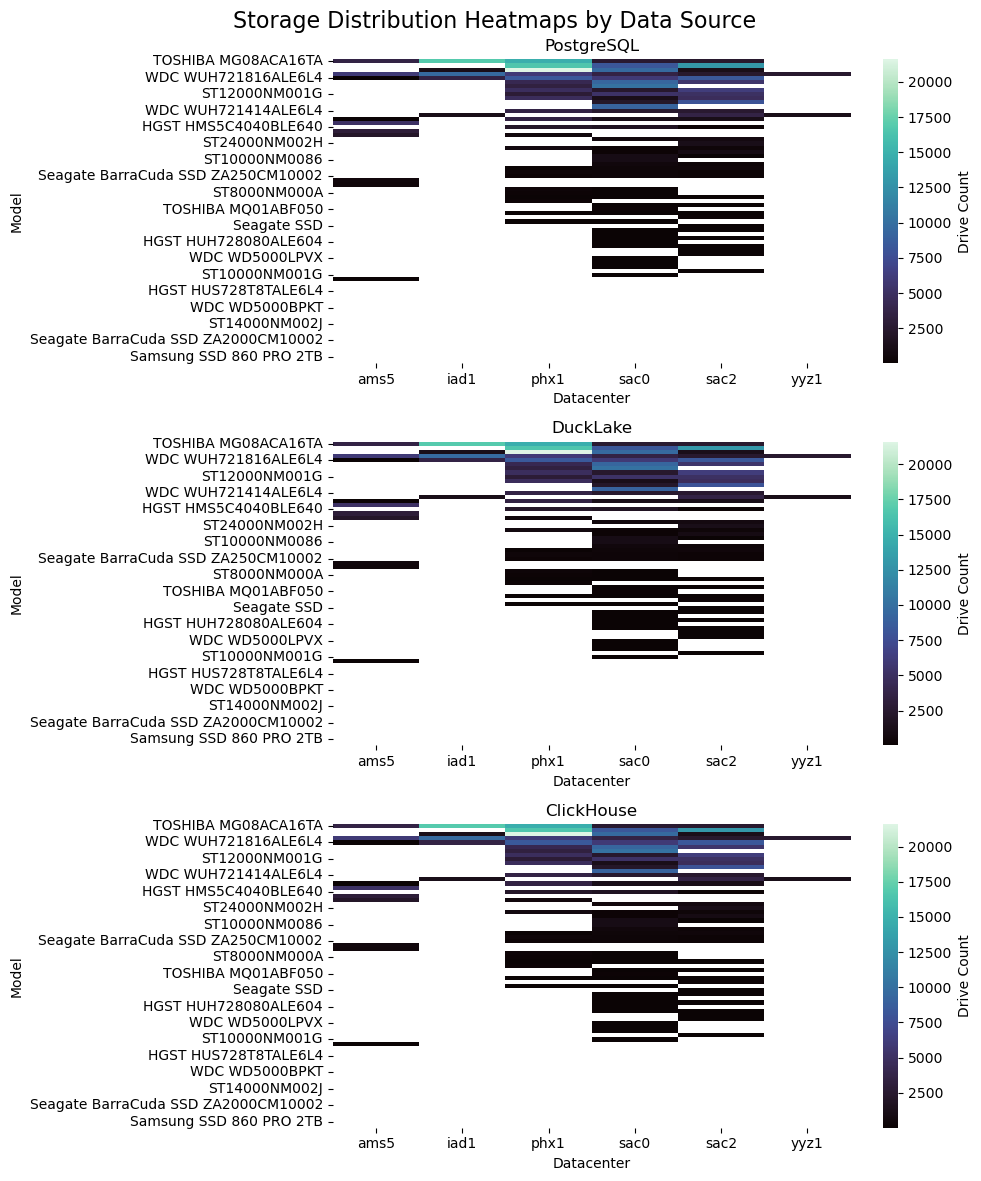

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
fig.suptitle('Storage Distribution Heatmaps by Data Source', fontsize=16)

# Create pivot tables for heatmaps
datasets = [
    (drive_count_per_model_datacenter_pg, 'PostgreSQL'),
    (drive_count_per_model_datacenter_dl, 'DuckLake'),
    (drive_count_per_model_datacenter_ch, 'ClickHouse'),
]

for idx, (data, title) in enumerate(datasets):
    row = idx

    pivot_data = data.pivot_table(
        index='model',
        columns='datacenter',
        values='drive_count',
        fill_value=0
    )

    pivot_data = pivot_data.loc[pivot_data.sum(
        axis=1).sort_values(ascending=False).index]

    # mask where less than 25 drives
    sns.heatmap(
        pivot_data,
        ax=axes[row],
        annot=False,
        cmap='mako',
        cbar_kws={'label': 'Drive Count'},
        mask=(pivot_data < 25)
    )

    axes[row].set_title(f'{title}')
    axes[row].set_ylabel('Model')
    axes[row].set_xlabel('Datacenter')

plt.tight_layout()
plt.show()

### Inspect total datacenter capacity over 2Q

In [42]:
%%time

datacenter_capacity_pg = pl.read_database_uri(
    query="""
        SELECT datacenter, date, sum(capacity_bytes) / 1024^5 as total_capacity_pib
        FROM raw.hard_drive_data
        GROUP BY datacenter, date
        ORDER BY 3 DESC
        """,
    uri=os.getenv("POSTGRES_CONN_STR"),
).to_pandas()
datacenter_capacity_pg

CPU times: user 8.21 ms, sys: 2.43 ms, total: 10.6 ms
Wall time: 59.3 s


,datacenter,date,total_capacity_pib
0,phx1,2025-06-16,1360.485966
1,phx1,2025-05-26,1360.484419
2,phx1,2025-06-01,1360.475534
3,phx1,2025-05-27,1360.461326
4,phx1,2025-06-12,1360.459321
...,...,...,...
1080,yyz1,2025-01-09,67.685420
1081,yyz1,2025-01-22,67.362122
1082,yyz1,2025-01-03,67.148952
1083,yyz1,2025-01-01,67.148952


In [39]:
%%time
datacenter_capacity_dl = con.execute(
    """
        SELECT datacenter, date, sum(capacity_bytes) / 1024^5 as total_capacity_pib
        FROM hard_drive_data
        GROUP BY datacenter, date
        ORDER BY 3 DESC
    """
).fetch_df()
datacenter_capacity_dl

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CPU times: user 877 ms, sys: 97.3 ms, total: 975 ms
Wall time: 2.99 s


,datacenter,date,total_capacity_pib
0,phx1,2025-06-16,1360.485966
1,phx1,2025-05-26,1360.484419
2,phx1,2025-06-01,1360.475534
3,phx1,2025-05-27,1360.461326
4,phx1,2025-06-12,1360.459321
...,...,...,...
1080,yyz1,2025-01-09,67.685420
1081,yyz1,2025-01-22,67.362122
1082,yyz1,2025-01-01,67.148952
1083,yyz1,2025-01-02,67.148952


In [60]:
%%time
datacenter_capacity_ch = ch_client.query_df(
    """
        SELECT datacenter, date, sum(capacity_bytes) / pow(1024, 5) as total_capacity_pib
        FROM dwh.backblaze_hard_drive_data 
        GROUP BY datacenter, date
        ORDER BY 3 DESC
        SETTINGS max_bytes_before_external_group_by = '1000000000'
    """
)
datacenter_capacity_ch

CPU times: user 3.12 ms, sys: 1.9 ms, total: 5.01 ms
Wall time: 1.92 s


,datacenter,date,total_capacity_pib
0,phx1,2025-06-16,1360.485966
1,phx1,2025-05-26,1360.484419
2,phx1,2025-06-01,1360.475534
3,phx1,2025-05-27,1360.461326
4,phx1,2025-06-12,1360.459321
...,...,...,...
1080,yyz1,2025-01-09,67.685420
1081,yyz1,2025-01-22,67.362122
1082,yyz1,2025-01-03,67.148952
1083,yyz1,2025-01-01,67.148952


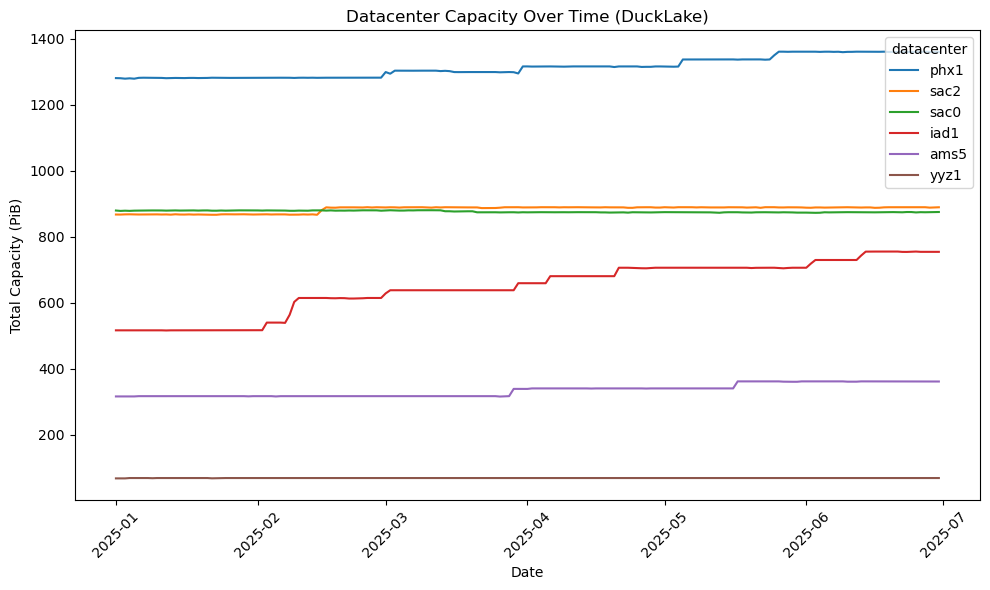

In [53]:
plt.figure(figsize=(10, 6))  # Increased width from default to 15
sns.lineplot(
    data=datacenter_capacity_dl,
    x='date',
    y='total_capacity_pib',
    hue='datacenter',
)
plt.title('Datacenter Capacity Over Time (DuckLake)')
plt.xlabel('Date')
plt.ylabel('Total Capacity (PiB)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()